In [1]:
# run this same experiment again but instead of 2,0,0 -> 0,0,2 have 2,0,0 -> 0,1,1 this would be cool 
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from qutip import Options
from tqdm import tqdm_notebook as tqdm
from progressbar import progressbar
from threading import Thread
from multiprocessing.pool import Pool, ThreadPool
from numpy.linalg import eig

# opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
# p_bar = qt.ui.TextProgressBar()  # None
opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6, "progress_bar": "text"}

In [2]:
# adding all of the necessary elements to the full creation of the system 
# doing this with a qubit first 
qubit_dim = 2

# frequencies 
w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435
g3s = 2 * np.pi * 0.04875

# create array of the coefficients should be useful 
gs = [g1s, g2s, g3s]

# unknown value as of now 
g3 = .1

alpha = [.1, .1, .1]
g13 = g23 = g12 = .01

In [3]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=qubit_dim, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=qubit_dim, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=qubit_dim, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])

freq_list  = [qubit1.freq / (2 * np.pi), qubit2.freq / (2 * np.pi), qubit3.freq / (2 * np.pi), snail.freq / (2 * np.pi)] 
gqq = [[qubit1.freq,g12,g13],[g12,qubit2.freq,g23],[g13,g23,qubit3.freq]]

In [5]:
# create the initial states of the qutrits
# physical qubits 
q = 1 # number of physical qubits 
qubit1_state = qt.basis(qubit_dim, 1) #+ qt.basis(qubit_dim, 1)  creating the encoded state with g and f 
qubit1_state /= qubit1_state.norm()

initial_encoded_state = qubit1_state
# prepare the ancillas in their respective states
# the qubit that i care about is the first one
for _ in range(2*q):
    initial_encoded_state = qt.tensor(initial_encoded_state, qt.basis(qubit_dim,0))
    initial_encoded_state /= initial_encoded_state.norm()
initial_encoded_state = qt.tensor(initial_encoded_state, qt.basis(snail.dim))
psi0 = initial_encoded_state 

In [6]:
# Hamiltonian construction
H_no_interaction = [freq_list[system.index(i)] * (qs.modes_a_dag[i] * qs.modes_a[i]) for i in system]
H_qubit_snail = [gs[qubits.index(i)] * (qs.modes_field[snail] * qs.modes_field[i]) for i in qubits]
H_qubit_qubit = [gqq[i][j] * (qs.modes_field[system[i]] * qs.modes_field[system[j]]) if j < i else 0 for i in range(3) for j in range(3)]
H_snail_third = [g3 * (qs.modes_field[snail] ** 3)]
H_qubit_fourth = [(alpha[qubits.index(i)]) * (qs.modes_field[i] ** 4) for i in qubits]

H_total_no_time = []
H_total_no_time.extend(H_no_interaction)
H_total_no_time.extend(H_qubit_snail)
H_total_no_time.extend(H_qubit_qubit)
H_total_no_time.extend(H_qubit_fourth)

In [15]:
H_no_time = sum(H_total_no_time)
full_time = 100
tlist_f_e = np.linspace(0,full_time,100)

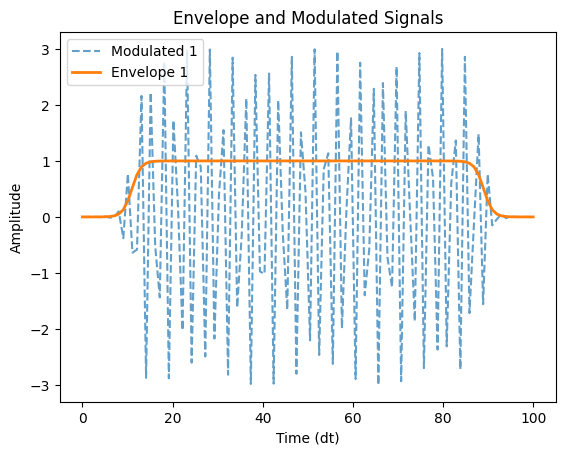

In [16]:
# creating the pulse and the hamiltonian pulse term
H_pump = qs.modes_a_dag[snail] + qs.modes_a[snail]
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time, "width": .9 * full_time}}
pulse = Pulse(omega=10, amp=3)
Pulse.plot_pulse([(pulse, args)], tlist_f_e)

In [ ]:
# final e state 
psie = qt.tensor(qt.basis(qubit_dim, 1), qt.basis(qubit_dim,0), qt.basis(qubit_dim, 0)).unit()

In [17]:
# need to find the pulse that moves the qubit from the f state into the e state which isnt hard 
amp = np.linspace(0,4,10)
freq = np.linspace(0,2,10)
amps_freqs = [(i, j) for i in amp for j in freq]
def sim_task_e(amp_freq):
    amp, freq = amp_freq
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time, "width": .9 * full_time}}
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
    H_total = [H_no_time, H_pump]

    result = qt.mesolve(H = H_total, rho0 = psi0, tlist = tlist_f_e, options = opts, args = args)

    fid = qt.fidelity(qt.ptrace(psie, [0,1,2]), qt.ptrace(result.states[-1], [0,1,2]))

    return amp, freq, fid

res = qt.parallel.parallel_map(sim_task_e, amps_freqs, progress_bar= True)



10.0%. Run time:   0.49s. Est. time left: 00:00:00:04
20.0%. Run time:   0.49s. Est. time left: 00:00:00:01
30.0%. Run time:   0.49s. Est. time left: 00:00:00:01
Total run time:   0.50s


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
# analyze the data from above
max_fid = 0
for i in range(len(res)):
    amp = res[i][0]
    freq = res[i][1] 
    fid = res[i][2]
    if max_fid < fid:
        max_fid = fid
        amp_res = amp
        freq_res = freq

print(f"The result of the sweep found a max fidelity of {max_fid} with amp: {amp_res} and freq: {freq_res}")

at this point you have the state that goes from the f to e state now you need to use the ancilla state and do a CNOT on this qubit and then after that send this qubit back to f 

In [ ]:
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time, "width": .9 * full_time}}
pulse = Pulse(omega=freq_res, amp=amp_res)
H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
H_total = [H_no_time, H_pump]
psie_res = qt.mesolve(H = H_total, rho0 = psi0, tlist = tlist_f_e, options = opts, args = args)
full_time_controlled = 100
tlist_controlled = np.linspace(0, full_time_controlled, 100)

In [ ]:
# now create the Controlled Z to get into the ancilla state
# this can be where you add the measurement portion of the code but this can be very risky think about it before you implement it 
psi_controlled_z_final = qt.tensor(-qt.basis(qubit_dim, 1), qt.basis(qubit_dim,0), qt.basis(qubit_dim, 0)).unit() # this is the final state after the controlled z has been applied 

def sim_task_controlled_z (amp_freq_controlled):
    amp, freq = amp_freq_controlled
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time_controlled, "width": .9 * full_time_controlled}}
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
    H_total = [H_no_time, H_pump]

    result = qt.mesolve(H = H_total, rho0 = psie_res.states[-1], tlist = tlist_controlled, options = opts, args = args)

    fid = qt.fidelity(qt.ptrace(psi_controlled_z_final, [0,1,2]), qt.ptrace(result.states[-1], [0,1,2]))

    return amp, freq, fid

res_controlled = qt.parallel.parallel_map(sim_task_e, amps_freqs, progress_bar= True)



In [ ]:
#####

In [ ]:
# take the state and make it into what you need it to be but break it down into its fundamentals first before having it act on the x 
# can create projection operators for this step but that can destroy the state because it is basically a measurement the best way to get around this is to 
# build the unitary for the Controlled z gate (this may be more mathematical tho give it a thought first before trying to program for the unitary here because it may actually
# be too expensive)

In [ ]:
#####

In [ ]:
# analyze the data from above
max_fid = 0
for i in range(len(res_controlled)):
    amp = res[i][0]
    freq = res[i][1] 
    fid = res[i][2]
    if max_fid < fid:
        max_fid = fid
        amp_res = amp
        freq_res = freq

print(f"The result of the sweep found a max fidelity of {max_fid} with amp: {amp_res} and freq: {freq_res}")

In [ ]:
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time_controlled, "width": .9 * full_time_controlled}}
pulse = Pulse(omega=freq_res, amp=amp_res)
H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
H_total = [H_no_time, H_pump]
psi_controlled_z_exec = qt.mesolve(H = H_total, rho0 = psie_res.states[-1], tlist = tlist_controlled, options = opts, args = args) # this is now the state after the controlled z has acted upon it 
full_time_e_f = 100
tlist_e_f = np.linspace(0, full_time_e_f, 100)

In [ ]:
psi_e_f = qt.tensor(-qt.basis(qubit_dim, 2), qt.basis(qubit_dim,0), qt.basis(qubit_dim, 0)).unit() # this is the final state of the program

def sim_task_controlled_z (amp_freq_e_f):
    amp, freq = amp_freq_e_f
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time_e_f, "width": .9 * full_time_e_f}}
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
    H_total = [H_no_time, H_pump]

    result = qt.mesolve(H = H_total, rho0 = psi_controlled_z_exec.states[-1], tlist = tlist_e_f, options = opts, args = args)

    fid = qt.fidelity(qt.ptrace(psi_e_f, [0,1,2]), qt.ptrace(result.states[-1], [0,1,2]))

    return amp, freq, fid

res_e_f = qt.parallel.parallel_map(sim_task_e, amps_freqs, progress_bar= True)

In [ ]:
# analyze the data from above
max_fid = 0
for i in range(len(res_e_f)):
    amp = res[i][0]
    freq = res[i][1] 
    fid = res[i][2]
    if max_fid < fid:
        max_fid = fid
        amp_res = amp
        freq_res = freq

print(f"The result of the sweep found a max fidelity of {max_fid} with amp: {amp_res} and freq: {freq_res}")

In [ ]:
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * full_time_e_f, "width": .9 * full_time_e_f}}
pulse = Pulse(omega=freq_res, amp=amp_res)
H_pump = [qs.modes_a_dag[snail] + qs.modes_a[snail], pulse.drive]
H_total = [H_no_time, H_pump]
psi_e_f = qt.mesolve(H = H_total, rho0 = psi_controlled_z_exec.states[-1], tlist = tlist_controlled, options = opts, args = args) # this is now the state after the controlled z has acted upon it 